<div style="border-radius:10px; border:#879410 solid; padding: 15px; background-color: #e8f573; font-size:100%; text-align:left">

<h3 align="left"><font color='#5c6317'>💡 Inspiration:</font></h3>
    
* **Purpose**: to create new faces of anime characters using a Deep Convolutional Generative Adversarial Network (**DCGAN**).

* This notebok demonstrates how to generate images of anime characters using a Deep Convolutional Generative Adversarial Network (**DCGAN**).


<div style="border-radius:10px; border:#879410 solid; padding: 15px; background-color: #e8f573; font-size:100%; text-align:left">

<h3 align="left"><font color='#5c6317'>What are GANs?</font></h3>
    
Generative Adversarial Networks (GANs) are one of the most interesting ideas in computer science today. Two models are trained simultaneously by an adversarial process. A generator ("the artist") learns to create images that look real, while a discriminator ("the art critic") learns to tell real images apart from fakes.

<div style="border-radius:10px; border:#879410 solid; padding: 15px; background-color: #e8f573; font-size:100%; text-align:left">

<h3 align="left"><font color='#5c6317'>Deep Convolutional GAN (DCGAN):</font></h3>
    
**DCGAN** is one of the most popular and also the most successful implementations of GAN. It is composed of ConvNets in place of multi-layer perceptrons. The ConvNets are implemented without max pooling, which is in fact replaced by convolutional stride. Also, the layers are not fully connected.

### <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#5c6317; font-size:140%; text-align:left;padding: 10px; border-bottom: 3px solid #879410"> Import Libraries</p>

In [1]:
!pip install torchvision

In [3]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
import torch.nn.functional as F
from torchvision.utils import save_image
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='darkgrid', font_scale=1.2)

### <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#5c6317; font-size:140%; text-align:left;padding: 10px; border-bottom: 3px solid #879410"> Loading and Preprocessing Dataset</p>

In [4]:
DATA_DIR = '/kaggle/input/anime-faces'

In [5]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [6]:
train_ds = ImageFolder(DATA_DIR, transform=tt.Compose([
    tt.Resize(image_size),
    tt.CenterCrop(image_size),
    tt.ToTensor(),
    tt.Normalize(*stats)]))


<div style="border-radius:10px; border:#879410 solid; padding: 15px; background-color: #e8f573; font-size:100%; text-align:left">
    
* The anime face images are of varied sizes. First, resize them to a fixed size of 64 x 64.
    
* Then normalize, using the mean and standard deviation of 0.5. Note that both mean & variance have three values, as you are dealing with an RGB image.
    
* The normalization maps the pixel values from the range [0, 255] to the range [-1, 1]. Mapping pixel values between [-1, 1] has proven useful while training GANs. 
* Also, convert the images to torch tensors.

In [8]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)

In [9]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [10]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

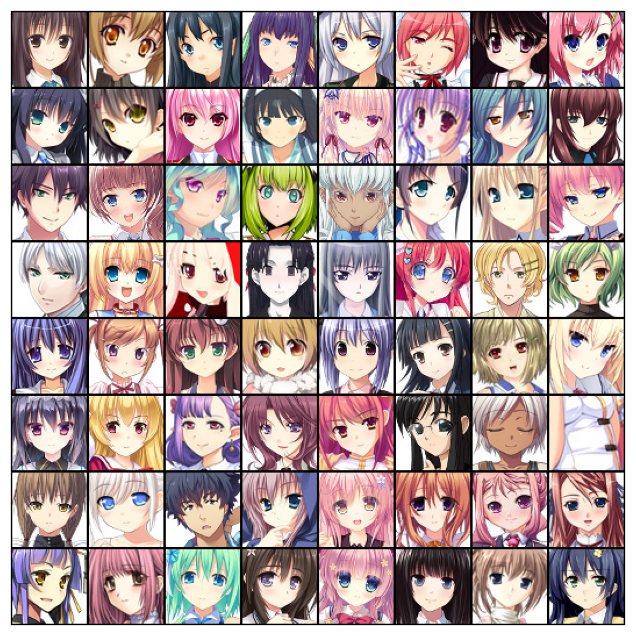

In [11]:
show_batch(train_dl)

In [12]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [13]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [14]:
train_dl = DeviceDataLoader(train_dl, device)

### <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#5c6317; font-size:140%; text-align:left;padding: 10px; border-bottom: 3px solid #879410">Discriminator Network </p>

In [15]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64
    
    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid()
)

In [16]:
discriminator = to_device(discriminator, device)

In [17]:
latent_size = 128

### <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#5c6317; font-size:140%; text-align:left;padding: 10px; border-bottom: 3px solid #879410">Generator Network </p>

In [18]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

torch.Size([128, 3, 64, 64])


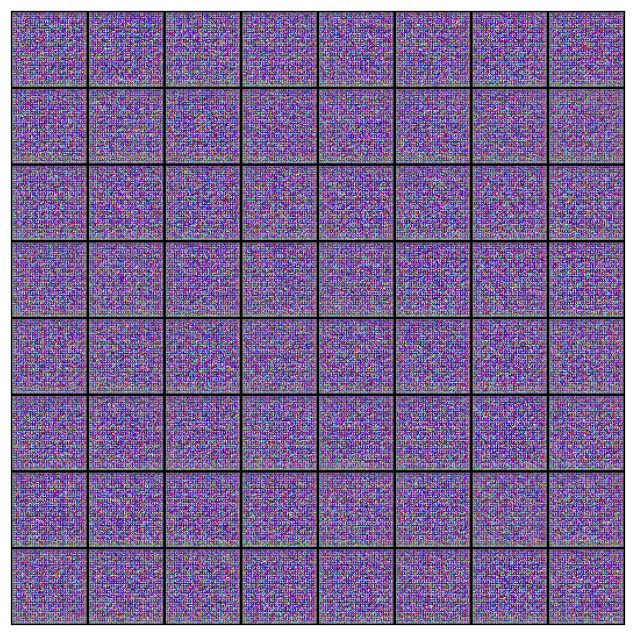

In [19]:
xb = torch.randn(batch_size, latent_size, 1, 1) 
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [20]:
generator = to_device(generator, device)

In [21]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [22]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

In [23]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

### <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#5c6317; font-size:140%; text-align:left;padding: 10px; border-bottom: 3px solid #879410">Training the Network </p>

In [24]:
def fit(model, criterion, epochs, lr, start_idx=1):
    model["discriminator"].train()
    model["generator"].train()
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    optimizer = {
        "discriminator": torch.optim.Adam(model["discriminator"].parameters(), 
                                          lr=lr, betas=(0.5, 0.999)),
        "generator": torch.optim.Adam(model["generator"].parameters(),
                                      lr=lr, betas=(0.5, 0.999))
    }
    
    for epoch in range(epochs):
        loss_d_per_epoch = []
        loss_g_per_epoch = []
        real_score_per_epoch = []
        fake_score_per_epoch = []
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            # Clear discriminator gradients
            optimizer["discriminator"].zero_grad()

            # Pass real images through discriminator
            real_preds = model["discriminator"](real_images)
            real_targets = torch.ones(real_images.size(0), 1, device=device)
            real_loss = criterion["discriminator"](real_preds, real_targets)
            cur_real_score = torch.mean(real_preds).item()
            
            # Generate fake images
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)

            # Pass fake images through discriminator
            fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
            fake_preds = model["discriminator"](fake_images)
            fake_loss = criterion["discriminator"](fake_preds, fake_targets)
            cur_fake_score = torch.mean(fake_preds).item()

            real_score_per_epoch.append(cur_real_score)
            fake_score_per_epoch.append(cur_fake_score)

            # Update discriminator weights
            loss_d = real_loss + fake_loss
            loss_d.backward()
            optimizer["discriminator"].step()
            loss_d_per_epoch.append(loss_d.item())


            # Train generator
            # Clear generator gradients
            optimizer["generator"].zero_grad()
            
            # Generate fake images
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)
            
            # Try to fool the discriminator
            preds = model["discriminator"](fake_images)
            targets = torch.ones(batch_size, 1, device=device)
            loss_g = criterion["generator"](preds, targets)
            
            # Update generator weights
            loss_g.backward()
            optimizer["generator"].step()
            loss_g_per_epoch.append(loss_g.item())
            
        # Record losses & scores
        losses_g.append(np.mean(loss_g_per_epoch))
        losses_d.append(np.mean(loss_d_per_epoch))
        real_scores.append(np.mean(real_score_per_epoch))
        fake_scores.append(np.mean(fake_score_per_epoch))
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, 
            losses_g[-1], losses_d[-1], real_scores[-1], fake_scores[-1]))
    
        # Save generated images
        if epoch == epochs - 1:
            save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [25]:
model = {
    "discriminator": discriminator.to(device),
    "generator": generator.to(device)
}

criterion = {
    "discriminator": nn.BCELoss(),
    "generator": nn.BCELoss()
}
lr = 0.0002
epochs = 55

In [26]:
history = fit(model, criterion, epochs, lr)

  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [1/55], loss_g: 4.9065, loss_d: 0.8258, real_score: 0.7437, fake_score: 0.2658


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [2/55], loss_g: 4.4561, loss_d: 0.7455, real_score: 0.7486, fake_score: 0.2484


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [3/55], loss_g: 5.0074, loss_d: 0.6491, real_score: 0.7751, fake_score: 0.2210


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [4/55], loss_g: 5.2716, loss_d: 0.6098, real_score: 0.7892, fake_score: 0.2074


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [5/55], loss_g: 5.5241, loss_d: 0.5160, real_score: 0.8188, fake_score: 0.1788


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [6/55], loss_g: 5.5754, loss_d: 0.4455, real_score: 0.8399, fake_score: 0.1565


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [7/55], loss_g: 5.7175, loss_d: 0.4285, real_score: 0.8501, fake_score: 0.1489


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [8/55], loss_g: 5.5987, loss_d: 0.3919, real_score: 0.8600, fake_score: 0.1384


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [9/55], loss_g: 5.7092, loss_d: 0.4100, real_score: 0.8613, fake_score: 0.1363


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [10/55], loss_g: 5.5089, loss_d: 0.3958, real_score: 0.8618, fake_score: 0.1364


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [11/55], loss_g: 5.3844, loss_d: 0.3662, real_score: 0.8704, fake_score: 0.1289


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [12/55], loss_g: 5.2753, loss_d: 0.3544, real_score: 0.8774, fake_score: 0.1232


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [13/55], loss_g: 5.1688, loss_d: 0.3376, real_score: 0.8798, fake_score: 0.1183


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [14/55], loss_g: 5.2515, loss_d: 0.3358, real_score: 0.8832, fake_score: 0.1159


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [15/55], loss_g: 5.1598, loss_d: 0.3748, real_score: 0.8780, fake_score: 0.1220


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [16/55], loss_g: 4.9405, loss_d: 0.2933, real_score: 0.8937, fake_score: 0.1046


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [17/55], loss_g: 5.0822, loss_d: 0.3642, real_score: 0.8828, fake_score: 0.1178


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [18/55], loss_g: 4.6292, loss_d: 0.2618, real_score: 0.9024, fake_score: 0.0965


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [19/55], loss_g: 4.8419, loss_d: 0.3855, real_score: 0.8827, fake_score: 0.1171


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [20/55], loss_g: 4.8635, loss_d: 0.3180, real_score: 0.8966, fake_score: 0.1032


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [21/55], loss_g: 4.7550, loss_d: 0.2815, real_score: 0.9028, fake_score: 0.0967


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [22/55], loss_g: 4.7480, loss_d: 0.3536, real_score: 0.9010, fake_score: 0.0990


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [23/55], loss_g: 4.4840, loss_d: 0.2870, real_score: 0.9037, fake_score: 0.0962


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [24/55], loss_g: 4.5726, loss_d: 0.3096, real_score: 0.9055, fake_score: 0.0941


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [25/55], loss_g: 4.7356, loss_d: 0.2754, real_score: 0.9081, fake_score: 0.0914


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [26/55], loss_g: 4.5838, loss_d: 0.2868, real_score: 0.9115, fake_score: 0.0884


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [27/55], loss_g: 4.4757, loss_d: 0.2568, real_score: 0.9166, fake_score: 0.0830


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [28/55], loss_g: 4.4230, loss_d: 0.3957, real_score: 0.8915, fake_score: 0.1088


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [29/55], loss_g: 4.4983, loss_d: 0.2408, real_score: 0.9182, fake_score: 0.0819


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [30/55], loss_g: 4.4348, loss_d: 0.3006, real_score: 0.9100, fake_score: 0.0899


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [31/55], loss_g: 4.5173, loss_d: 0.2655, real_score: 0.9164, fake_score: 0.0835


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [32/55], loss_g: 4.3148, loss_d: 0.2479, real_score: 0.9238, fake_score: 0.0759


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [33/55], loss_g: 4.5081, loss_d: 0.2954, real_score: 0.9131, fake_score: 0.0867


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [34/55], loss_g: 4.8015, loss_d: 0.2070, real_score: 0.9275, fake_score: 0.0726


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [35/55], loss_g: 4.5555, loss_d: 0.2846, real_score: 0.9202, fake_score: 0.0797


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [36/55], loss_g: 4.6567, loss_d: 0.4095, real_score: 0.9227, fake_score: 0.0787


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [37/55], loss_g: 4.4959, loss_d: 0.1584, real_score: 0.9377, fake_score: 0.0616


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [38/55], loss_g: 4.6041, loss_d: 0.1971, real_score: 0.9438, fake_score: 0.0562


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [39/55], loss_g: 4.8269, loss_d: 0.2860, real_score: 0.9217, fake_score: 0.0788


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [40/55], loss_g: 4.8124, loss_d: 0.1457, real_score: 0.9452, fake_score: 0.0543


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [41/55], loss_g: 4.7218, loss_d: 0.2571, real_score: 0.9418, fake_score: 0.0582


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [42/55], loss_g: 4.6920, loss_d: 0.2859, real_score: 0.9186, fake_score: 0.0815


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [43/55], loss_g: 4.5650, loss_d: 0.3166, real_score: 0.9213, fake_score: 0.0784


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [44/55], loss_g: 4.7151, loss_d: 0.0937, real_score: 0.9593, fake_score: 0.0409


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [45/55], loss_g: 4.7508, loss_d: 0.2545, real_score: 0.9370, fake_score: 0.0625


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [46/55], loss_g: 4.5371, loss_d: 0.3576, real_score: 0.9113, fake_score: 0.0896


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [47/55], loss_g: 4.7790, loss_d: 0.1653, real_score: 0.9442, fake_score: 0.0560


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [48/55], loss_g: 4.7824, loss_d: 0.2375, real_score: 0.9452, fake_score: 0.0546


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [49/55], loss_g: 4.7737, loss_d: 0.2526, real_score: 0.9387, fake_score: 0.0620


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [50/55], loss_g: 4.9609, loss_d: 0.1501, real_score: 0.9511, fake_score: 0.0491


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [51/55], loss_g: 5.2192, loss_d: 0.0465, real_score: 0.9781, fake_score: 0.0219


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [52/55], loss_g: 5.2417, loss_d: 0.4435, real_score: 0.9288, fake_score: 0.0727


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [53/55], loss_g: 4.8784, loss_d: 0.1635, real_score: 0.9491, fake_score: 0.0506


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [54/55], loss_g: 4.9782, loss_d: 0.1597, real_score: 0.9532, fake_score: 0.0471


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [55/55], loss_g: 5.1388, loss_d: 0.2209, real_score: 0.9559, fake_score: 0.0439
Saving generated-images-0055.png


### <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#5c6317; font-size:140%; text-align:left;padding: 10px; border-bottom: 3px solid #879410">Loss Function </p>

In [28]:
losses_g, losses_d, real_scores, fake_scores = history

In [29]:
generated_img = cv2.imread(f'./generated/generated-images-00{epochs}.png')
generated_img = generated_img[:, :, [2, 1, 0]]

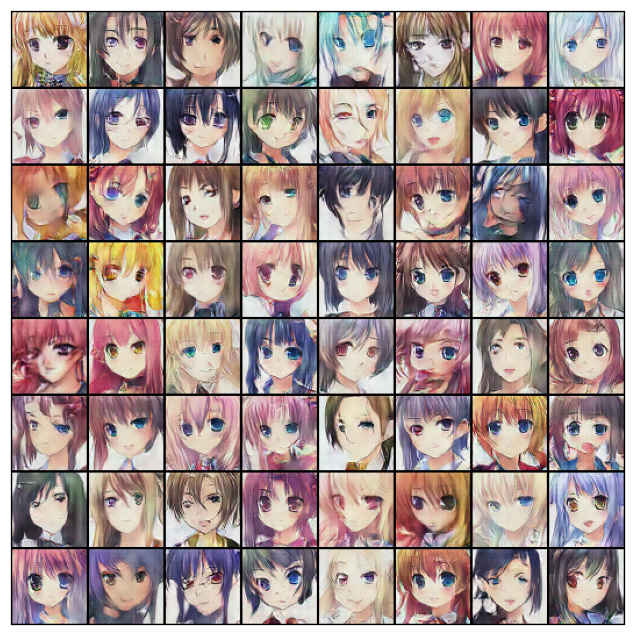

In [30]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xticks([]); ax.set_yticks([])
ax.imshow(generated_img)

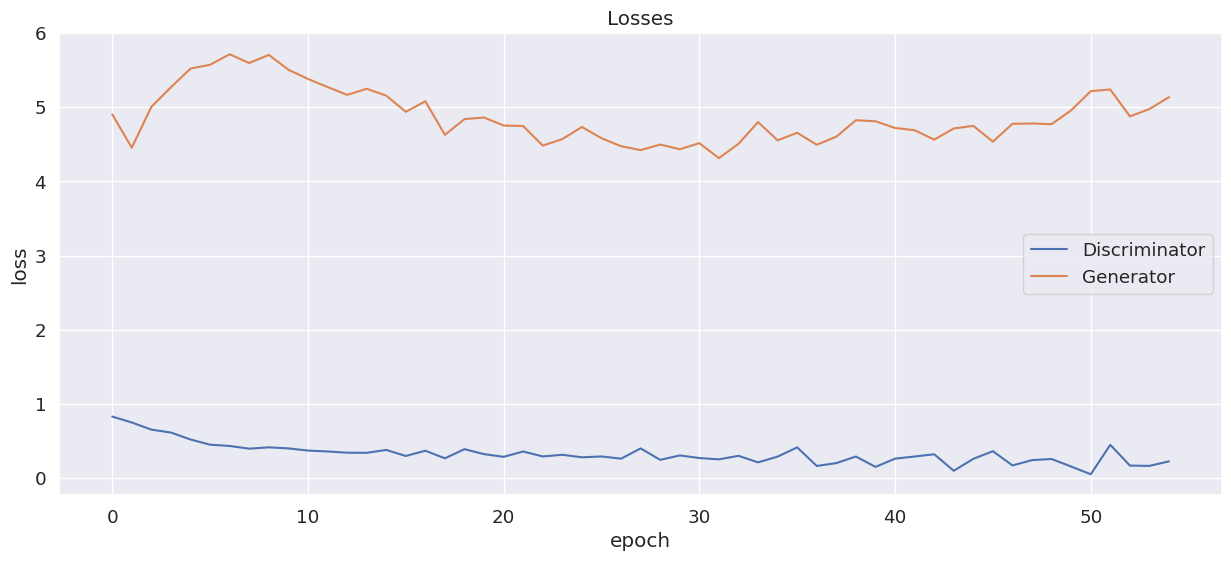

In [31]:
plt.figure(figsize=(15, 6))
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

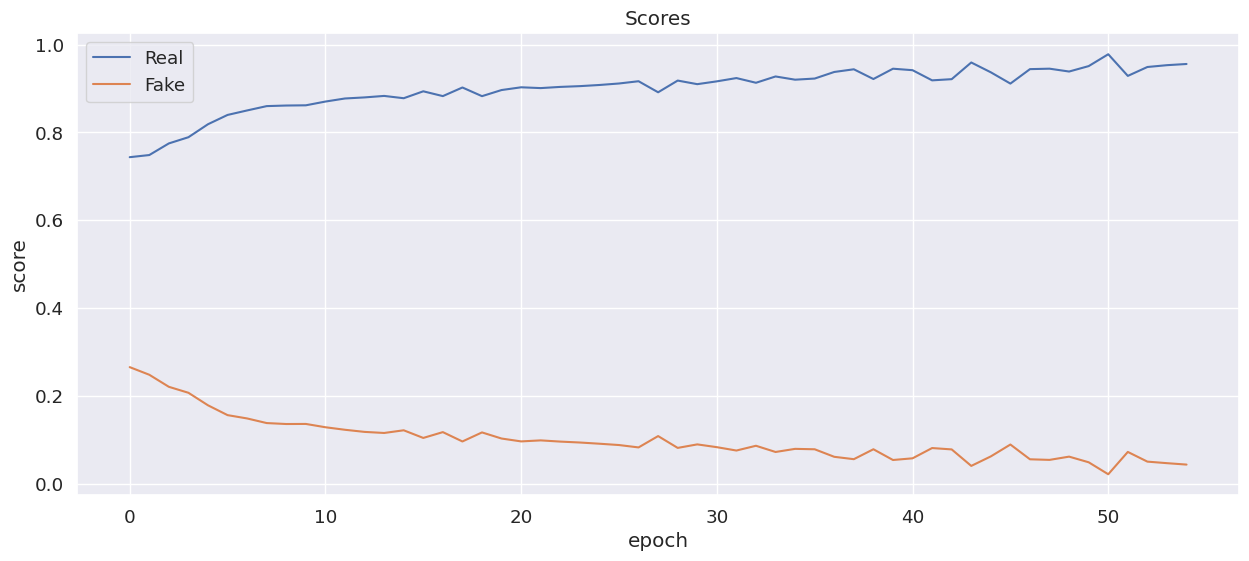

In [32]:
plt.figure(figsize=(15, 6))

plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');